In [4]:
import numpy as np
import scipy as sp
from scipy import stats
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import sklearn.manifold as manifold
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import math
import sklearn.decomposition as skd
import sklearn.manifold as skms
import sklearn.preprocessing as skp
sns.set(style='white', color_codes=True, font_scale=1.3)

# make the Pandas tables a little more readable
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [82]:
#helper functions

#calculates r2 using spearman correlation as my data proved not to be normal
def r2(x, y):
#     return stats.pearsonr(x, y)[0] ** 2
#     return stats.kendalltau(x, y)
    return stats.spearmanr(x, y)[0] ** 2



#a possitive corr_thresh will give you columns with positive correlation, and vice versa with negative correlations
def get_cols_with_corr(df, corr_thresh):
    df_corr = df.copy()
    df_corr = df_corr.corr()
    df_corr.loc[:,:] =  np.tril(df_corr, k=-1) # borrowed from Karl D's answer
    result = []
    already_in = set()
    for col in df_corr:
        if corr_thresh < 0:
            a_corr = df_corr[col][(df_corr[col] <= corr_thresh)].index.tolist()
        else:
            a_corr = df_corr[col][(df_corr[col] >= corr_thresh)].index.tolist()
        if a_corr and col not in already_in:
            already_in.update(set(a_corr))
            a_corr.append(col)
            result.append(a_corr)
            return result

# removes duplicate items in a list of lists 
def duplicate_rm(lst):
    a_set = set(tuple(x) for x in lst)
    a_corr = [ list(x) for x in a_set ]
    return a_corr
#normalizes dataframe 
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

# adapted from here: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# takes as input the frame, and a list of cluster sizes to try
def plotSilhouette(X,range_n_clusters=[2, 3, 4, 5, 6]):
    X = X.as_matrix()

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()



## importing and cleaning data

In [6]:
#reading in my CSV data, and encoding it to the right format
df_raw = pd.read_csv('Most-Recent-Cohorts-All-Data-Elements.csv', encoding='"ISO-8859-1"')
df_raw.shape


C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6,9,1170,1171,1172,1173,1174,1175,1177,1178,1179,1181,1183,1184,1185,1186,1187,1188,1190,1192,1196,1198,1199,1200,1201,1209,1211,1212,1213,1214,1222,1223,1224,1225,1226,1227,1235,1236,1237,1238,1239,1240,1248,1249,1251,1252,1253,1257,1261,1262,1264,1265,1266,1270,1274,1275,1276,1277,1278,1279,1282,1283,1287,1288,1289,1290,1291,1292,1295,1296,1309,1322,1326,1327,1328,1329,1330,1331,1333,1334,1335,1339,1340,1341,1342,1343,1344,1346,1347,1348,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1411,1425,1427,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1517,1529,1530,1532,1537,1540,1541,1542,1546,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1605,1606,1608,1609,1610,1613,1614,161

(7703, 1743)

In [7]:
#filtering the dataframe to contain schools who mainly award bachelors degrees, are the main campus that are currently open,
# and excludes private for profit insitutions into a new data frame

df_filtered = df_raw.copy()
df_filtered = df_filtered[df_filtered.PREDDEG == 3]
df_filtered = df_filtered[df_filtered.MAIN == 1]
df_filtered = df_filtered[df_filtered.CONTROL != 3]
df_filtered = df_filtered[df_filtered.CURROPER == 1]
df_filtered.shape
#df_filtered.head()

(1735, 1743)

In [8]:

#attempted to categorize norminal data as type category, but this proved to make my data harder to analyse 
#converting nominal data into categories
#used college score cards data dictionary to identify nominal and categorial variables
nominal_col_lst = ['HIGHDEG', 'CONTROL', 'ST_FIPS', 'REGION', 'LOCALE', 'LOCALE2', 'CCBASIC', 'CCUGPROF', 'CCSIZSET', 'HBCU', 'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'HSI', 'NANTI', 'MENONLY', 'WOMENONLY', 'RELAFFIL', 'DISTANCEONLY', 'ICLEVEL']
df_cat = df_filtered.copy()
# for col in df_cat:
#     if col in nominal_col_lst:
#         df_cat[col] = df_cat[col].astype(dtype='category')

#setting the index of my dataframe to the name of the school or institution into a new data frame 
df_f_index = df_cat.copy()
df_f_index = df_f_index.set_index('INSTNM')

#handeling missing data by replacing PrivacySuppressed values and NaN values to 0 into a new data frames 
##droping na values before this step, proved to destroy inmportant data needed for analysis
# df_priv_is_0 = df_cat.copy()
df_priv_is_0 = df_f_index.copy()
df_priv_is_0 = df_priv_is_0.replace(to_replace='PrivacySuppressed', value=0)
df_priv_is_0 = df_priv_is_0.fillna(0)
df_nonull = df_priv_is_0.copy().dropna()
df_nonull2 = df_priv_is_0.copy().dropna(axis=1)

#print(df_priv_is_0)
print('shape of the raw data: ', df_raw.shape)
print('shape of the filtered data ',df_filtered.shape )
print('shape of data after accounting for missing values ', df_nonull.shape )
print('the shape of the data after dropna(axis=1) is', df_nonull2.shape)
# print(df_nomull2.columns.values)
# print(df_nonull2.shape)
# print(df_nonull.shape)


shape of the raw data:  (7703, 1743)
shape of the filtered data  (1735, 1743)
shape of data after accounting for missing values  (1735, 1742)
the shape of the data after dropna(axis=1) is (1735, 1742)


In [9]:
# sns.regplot(df_nonull["COUNT_WNE_P10"].astype(int), df_nonull['DEP_INC_N'].astype(int))
# sns.regplot(df_nonull["MN_EARN_WNE_P10"].astype(float), df_nonull['DEP_INC_AVG'].astype(float))


## addition of weighted variables that are of interest

In [10]:


#weighting variables
weighted_avg_earn_10 = (df_nonull["MN_EARN_WNE_P10"].astype(float) * df_nonull["COUNT_WNE_P10"].astype(int))
weighted_dep_inc = (df_nonull['DEP_INC_AVG'].astype(float) * df_nonull['DEP_INC_N'].astype(int))
weighted_ind_inc =  (df_nonull['IND_INC_AVG'].astype(float) * df_nonull['IND_INC_N'].astype(int))

        

#addition of columns after weighting to be used in correlation
df_a = df_nonull.copy()
df_a["weight_avg__earn_10"], df_nonull2["weight_avg__earn_10"] = weighted_avg_earn_10, weighted_avg_earn_10
df_a["weighted_dep_inc"], df_nonull2["weighted_dep_inc"] = weighted_dep_inc, weighted_dep_inc
df_a['weighted_ind_inc'], df_nonull2['weighted_ind_inc'] = weighted_ind_inc, weighted_ind_inc

In [11]:
#df_priv_is_0.ix[0]

## testing normality of data and running correlation analysis

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


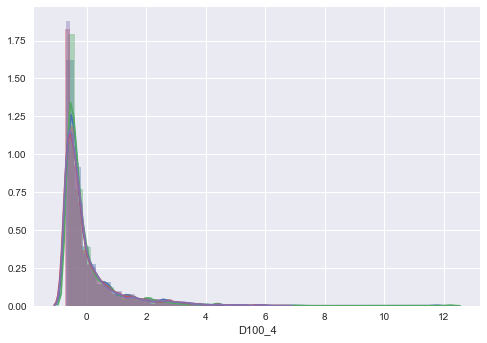

In [37]:

#nomalized data of variables identified as most relevant -- happens further down in notebook
# showing distribution plots overlayed

#values are still skewed to the left, meaning data is still not normally distributed, and spearmans correlation will
#continued to be used, and the normalized_df will not be considered as normalization was already accounted for in 
#the dataset with the most relevant variables
normalized_df=(most_r-most_r.mean())/most_r.std()
for col in normalized_df.columns.values:
    sns.distplot(normalized_df[col])

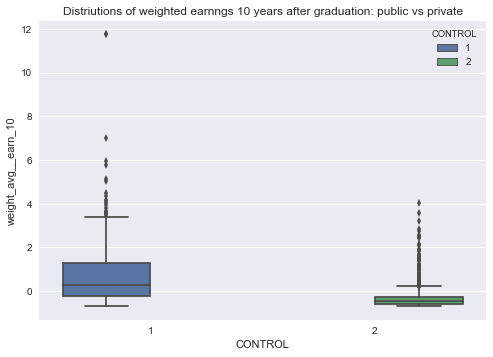

In [219]:
df_a_with_norm_earn = df_a.copy()
df_a_with_norm_earn['weight_avg__earn_10'] = (df_a['weight_avg__earn_10']-df_a['weight_avg__earn_10'].mean())/df_a['weight_avg__earn_10'].std()
#shows that public universities have a larger spead of earnings, vs private universities

ax = plt.axes()
sns.boxplot(x="CONTROL", y="weight_avg__earn_10", hue="CONTROL", data=df_a_with_norm_earn, ax=ax)

ax.set_title('Distriutions of weighted earnngs 10 years after graduation: public vs private')
plt.show()

r squared is  0.758253800329 for dependents
r squared is  0.421874278666 for independents
Axes(0.125,0.125;0.775x0.755)
p value for weighted_avg_earn_10  0.0
Axes(0.125,0.125;0.775x0.755)
p value for weighted_dep_inc  0.0


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


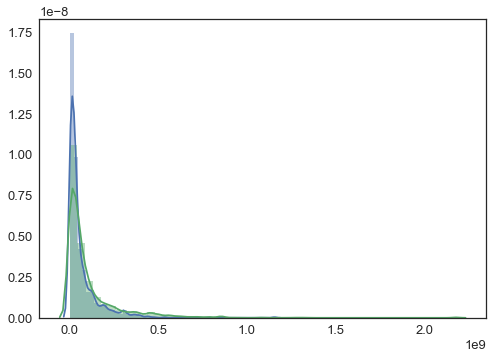

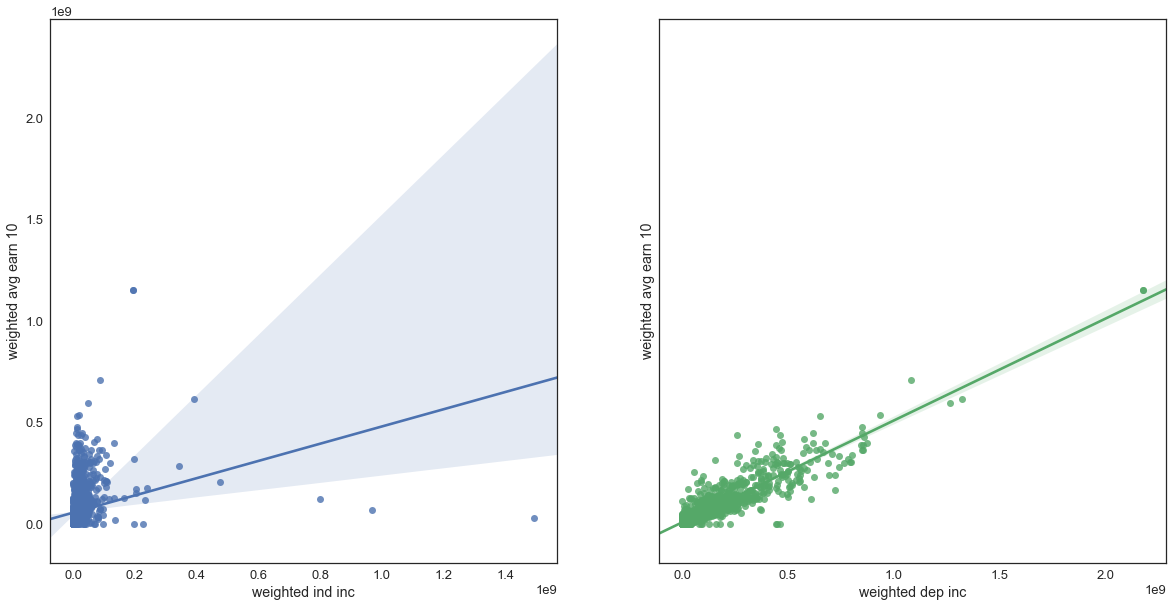

In [12]:
#testing if data is normally distributed

print("r squared is ", r2(weighted_dep_inc, weighted_avg_earn_10), "for dependents")
print("r squared is ", r2(weighted_ind_inc, weighted_avg_earn_10), "for independents")


#these overlayed histograms show my data is not normally distributed, and the spearman method has been chosen for correlation
print(sns.distplot(weighted_avg_earn_10))
print("p value for weighted_avg_earn_10 ", stats.normaltest(weighted_avg_earn_10)[1])
print(sns.distplot(weighted_dep_inc))
print("p value for weighted_dep_inc ",stats.normaltest(weighted_dep_inc)[1])

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(20,10))
ax1 = sns.regplot(x=weighted_ind_inc, y=weighted_avg_earn_10, ax=ax1)
ax2 = sns.regplot(x=weighted_dep_inc, y=weighted_avg_earn_10, ax=ax2)

# ax = sns.regplot(weighted_ind_inc, weighted_avg_earn_10  )
ax1.set(ylabel='weighted avg earn 10', xlabel='weighted ind inc')
ax2.set(ylabel='weighted avg earn 10', xlabel='weighted dep inc')
plt.show()

# the histograms show that the data is not normally distributed and thus spearmans correlation will be used 

shows that there is a moderate correlation between the a dependents students family income and their earnings 10 years out of school, but almost no correlation between earnings in 10 years and independent income -- using spearman correlation because my data is not normal. moving forward because of the litter correlation, the weighted independt inncome will not be used for analysys

In [13]:
df_a_corr = df_a.copy()
df_a_corr = df_a_corr.corr(method='spearman')
#df_nonull_corr.loc[:,:] =  np.tril(df_nonull_corr, k=-1) # borrowed from Karl D's answer

# attempts to isolate correlated variables into lists -- this did not prove to be very useful in the end, 
# because not all data columns were relevant to my research
pos_corr = list()
neg_corr = list()

pos_corr = get_cols_with_corr(df_a_corr, 0.5)
neg_corr = get_cols_with_corr(df_a_corr, -0.3)
    
pos_corr = duplicate_rm(pos_corr)
neg_corr = duplicate_rm(neg_corr)
            
print(len(pos_corr))
print(len(neg_corr))
print(df_a_corr.shape)
print(df_a_corr.shape)


1
1
(511, 511)
(511, 511)


In [14]:
#prints out lists of correlated variables, it was noted that some of the correlated variables were not relevant to my 
#research

# for i in pos_corr:
#     print("\n",i)
# print('\n-----------------\n negatives \n ----------------')
# for i in neg_corr:
#     print("\n ", i)
    


In [15]:
# weighted_avg_earn_10 = (df_nonull["MN_EARN_WNE_P10"].astype(float) * df_nonull["COUNT_WNE_P10"].astype(int))
# weighted_dep_inc = (df_nonull['DEP_INC_AVG'].astype(float) * df_nonull['DEP_INC_N'].astype(int))

# matrix = df_a[['DEP_INC_AVG',"COUNT_WNE_P10", 'DEP_INC_N', "MN_EARN_WNE_P10"]].corr()

# used to show the differences between 2 dataframes that handeled nulls differently, after reevaluating my methods
# elucidating these differences proved to be useless as both data frames became the same
cor_var_list = []
for col in df_a_corr:
    cor_var_list.append(col)
print(len(cor_var_list))

df_a_f_col = df_a[df_a_corr.columns].copy()
print(df_a_f_col.shape)

#puts column names not included in df_a after removal of nulls
notin2 = []
for col in df_a.columns.values:
    if col not in df_nonull2.columns.values:
        notin2.append(col)
print(len(notin2))
print(notin2)



511
(1735, 511)
0
[]


In [16]:

# fig, ax = plt.subplots(figsize=(100,100))         # Sample figsize in inches
# ax = sns.set(font_scale=1)
# ax = sns.heatmap(df_nonull.corr())
# plt.show()
print(df_a.corr().shape)
print(df_a_f_col.corr().shape)

(511, 511)
(511, 511)


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in greater_equal


511
404
over80p shape (1428, 404)
over80p corr shape (404, 404)


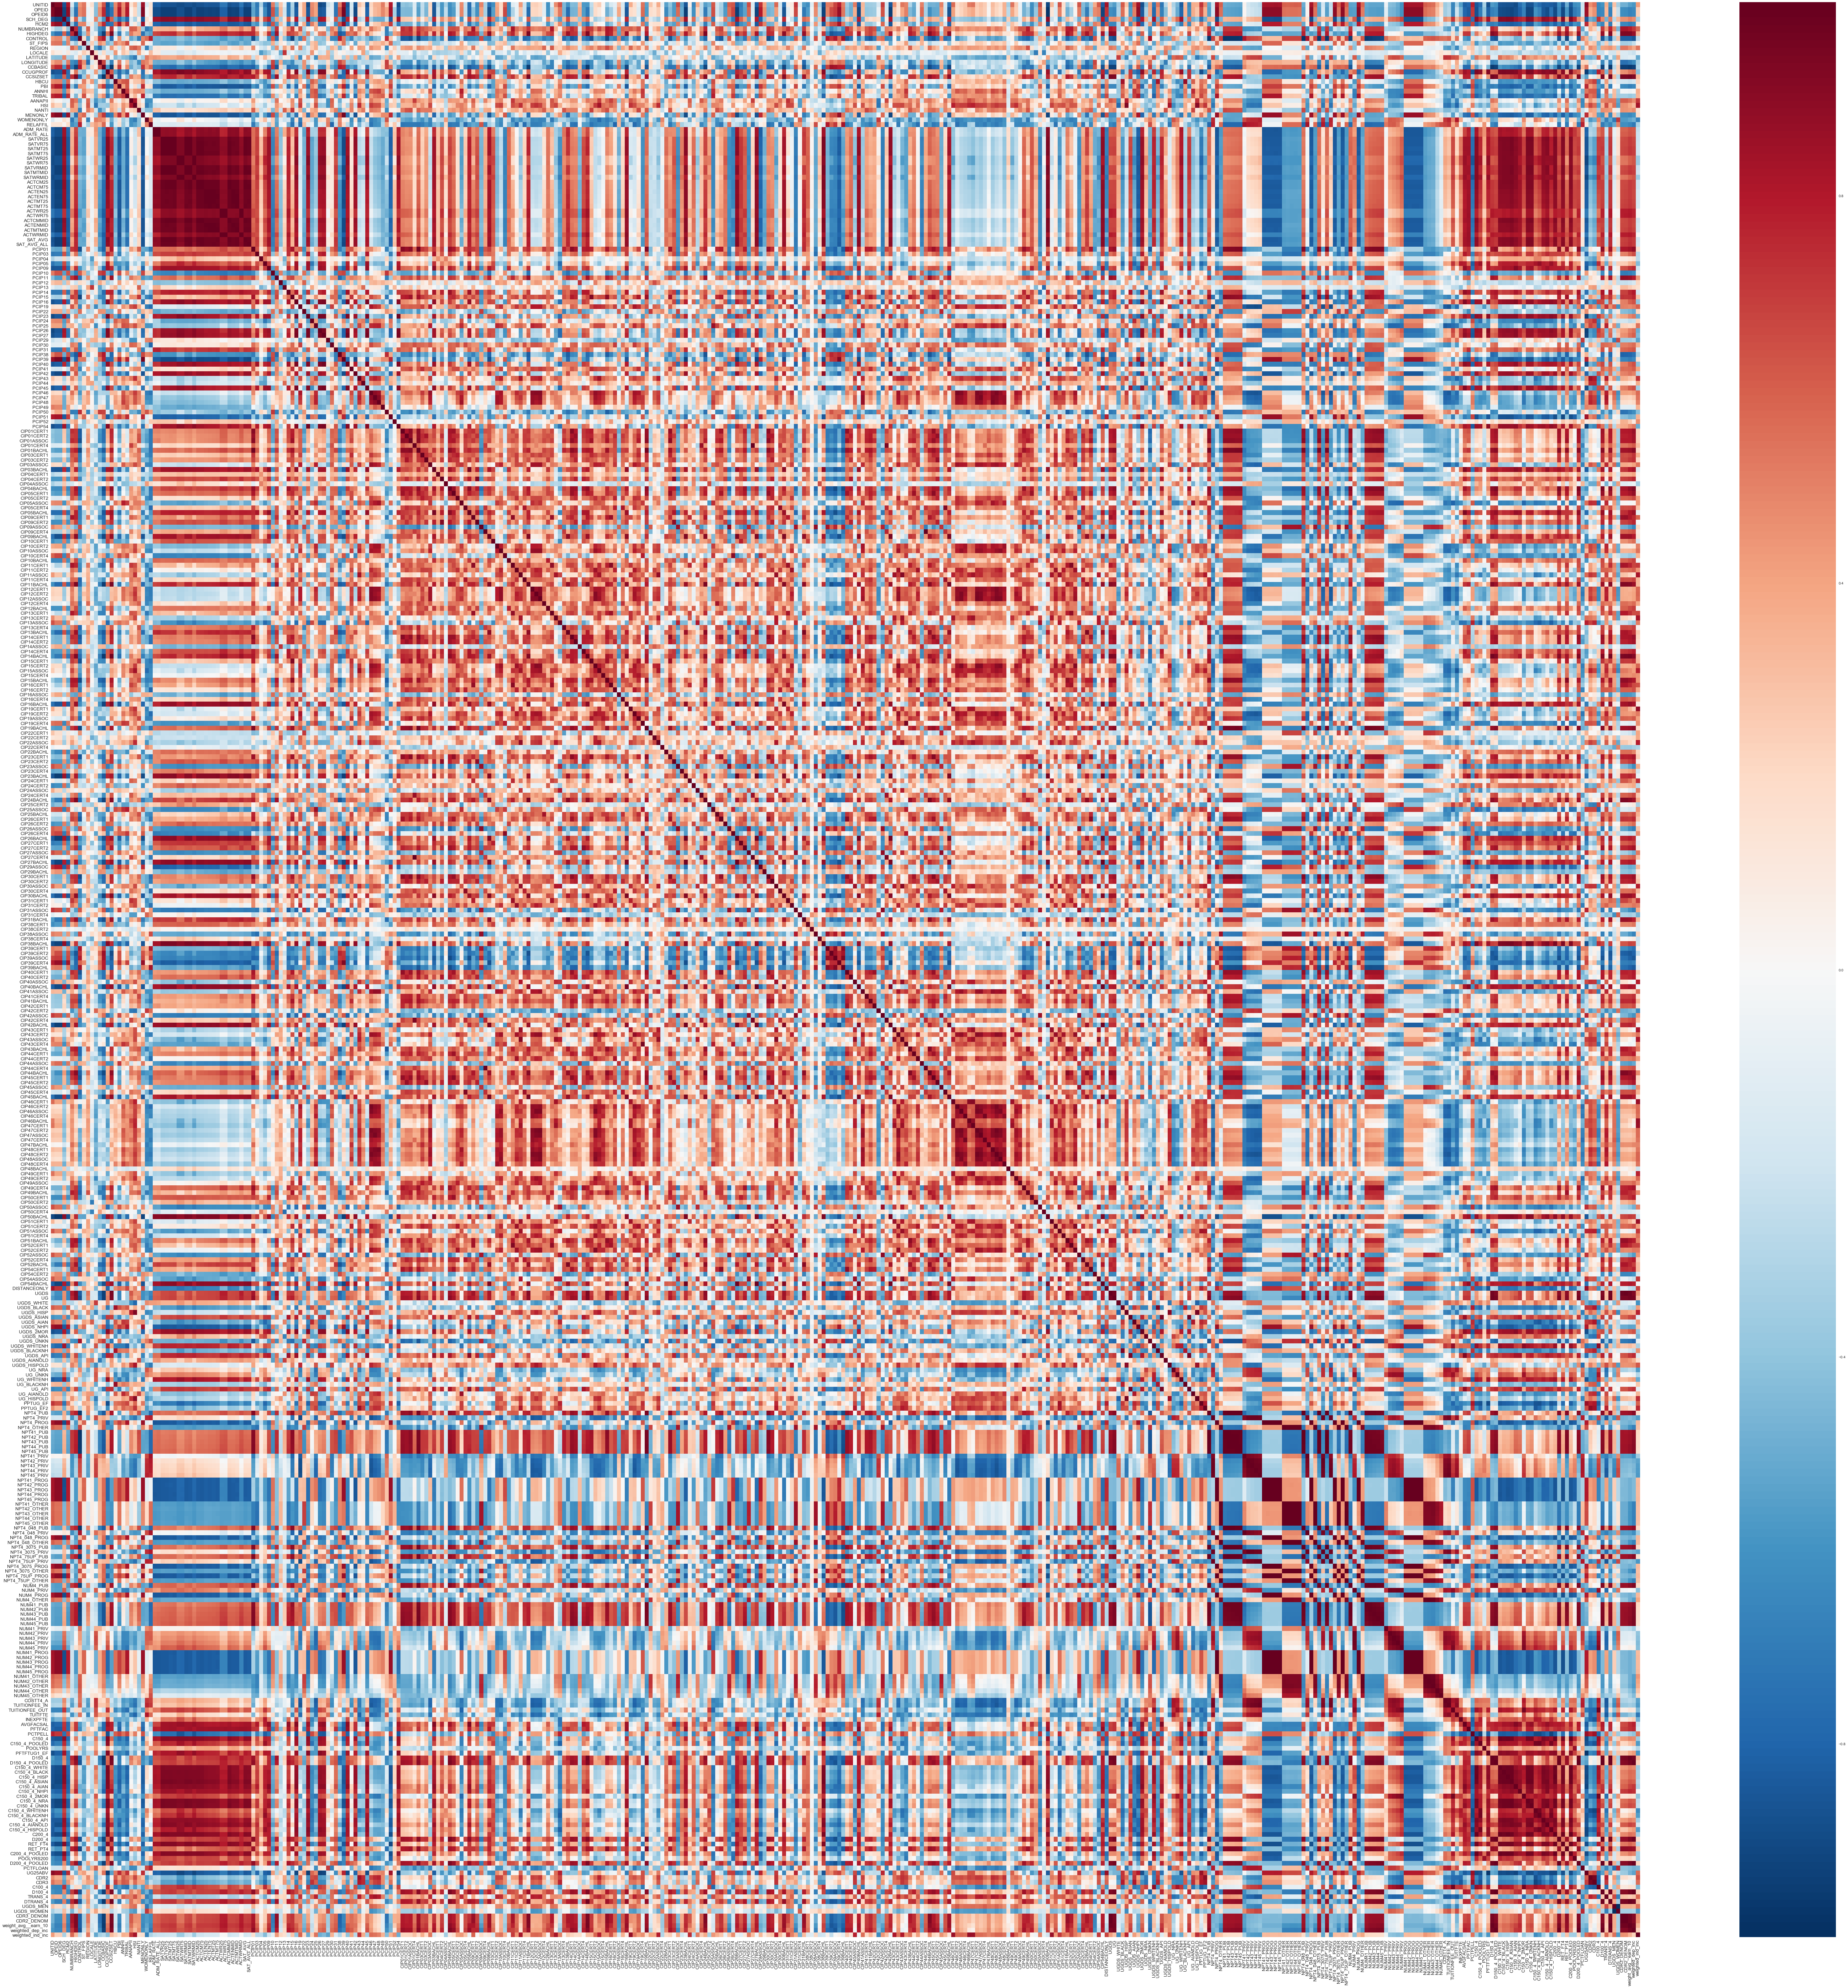

In [17]:
#creates a variable that contains the correlation matrix for the d_a_f_col dataframe

ColCorr = df_a_f_col.corr(method='spearman')
 
# isolates columns that contain a correlation of .8 or higher into a new datafame
x = ColCorr[abs(ColCorr.values >= 0.8)]

# collecting the list of variables with NaN correlations
corr_nan_col =[col for col in x.columns if math.isnan(x[col][0])]
#collecting the list of variables with some correlations
corr_col_no_nan = [col for col in x.columns if not math.isnan(x[col][0])]

print(len(df_a_f_col.corr()))
print(len(df_a[corr_col_no_nan].corr()))


#creats heatmaps with columns who has a correlation of 0.8 and do not have nan corralations
over80p = df_a[corr_col_no_nan].corr()[df_a[corr_col_no_nan].corr().values >= 0.8]
# sns.heatmap(over80p)
print('over80p shape', over80p.shape)
print('over80p corr shape', over80p.corr(method="spearman").shape)
fig, ax = plt.subplots(figsize=(100,100))         # Sample figsize in inches
ax = sns.set(font_scale=1)
ax = sns.heatmap(over80p.corr(method="spearman"))
plt.show()


##use this heat map to creeat a small list of somewhat related variables to answer my research questions more aquratly.

In [19]:
#lists of some of the variables that were shown to be correlated
lst = ['C150_4',"LOCALE",'CIP05BACHL', 'CIP11BACHL', 'CIP14BACHL', 'CIP16BACHL', 'CIP26BACHL', 'CIP27BACHL', 'CIP40BACHL', 'CIP45BACHL', 'CIP54BACHL', 'UGDS', 'UG', 'NPT4_PUB', 'NUM4_PUB', 'AVGFACSAL', 'D150_4', 'D150_4_POOLED', 'C150_4_ASIAN', 'D200_4', 'RET_FT4', 'D200_4_POOLED', 'D100_4', 'DTRANS_4', 'CDR3_DENOM', 'CDR2_DENOM', 'weight_avg__earn_10', 'weighted_dep_inc', 'CCSIZSET']
lst2 = ['C150_4_BLACKNH', 'C150_4_API', 'C150_4_AIANOLD', 'C150_4_HISPOLD', 'C200_4', 'C200_4_POOLED', 'C100_4', 'C150_4_WHITENH']
lst3 = ['PCTPELL', 'UG25ABV', 'ACTMTMID']
lst4 = ['COSTT4_A', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'C150_4', 'C150_4_POOLED', 'PFTFTUG1_EF', 'C150_4_WHITE', 'C150_4_BLACK', 'C150_4_HISP', 'C150_4_ASIAN', 'C200_4', 'RET_FT4', 'C200_4_POOLED', 'C100_4', 'PCIP43']
lst5 = ['C100_4','PCTPELL', 'UG25ABV', 'ACTMT25', 'ACTMT75']
#variables identified me to be the most relevant
print(len(lst))
m = df_a_corr[lst].corr(method='spearman')
n = df_a_corr[lst2].corr(method='spearman')
o = df_a_corr[lst3].corr(method='spearman')
p = df_a_corr[lst4].corr(method='spearman')
q = df_a_corr[lst5].corr(method='spearman')

29


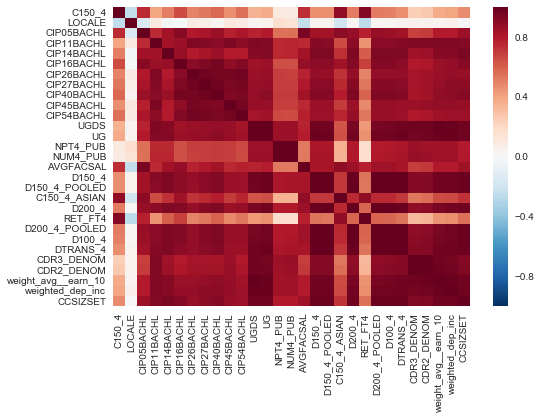

In [20]:
#correlation heatmap showing the correlation for one of the lists of related variables that were identified
sns.heatmap(m)

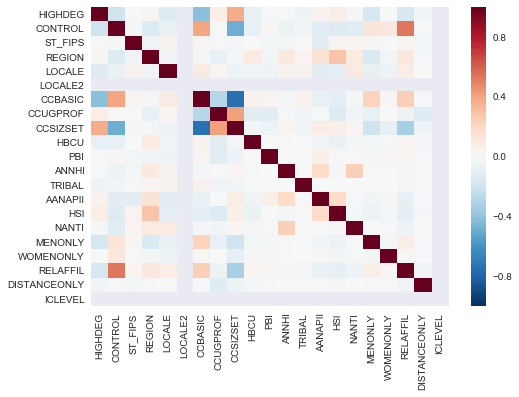

In [21]:
#heatmap of correlations of nominal data, there isnt anything too interesting in here 
# mostly shows that the religious affiliation is most closley corelated to whether or not the institution is public or private
categorical_corr = df_nonull[nominal_col_lst].corr(method='spearman')
sns.heatmap(categorical_corr)


In [ ]:
#sns.heatmap(df_nonull2[corr_col_no_nan].corr())

25


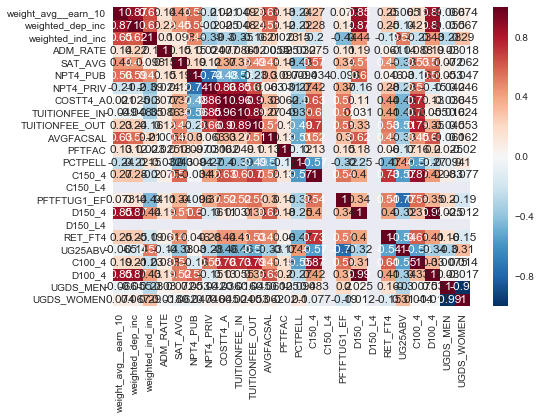

In [22]:
#using the large heat map and through manual digging i identified variables which i thought would be useful for futher analysis
#those variable names are stored in f_lst

#using this list i created a heatmap to show their correlations 
f_lst = ['weight_avg__earn_10', 'weighted_dep_inc', 'weighted_ind_inc','ADM_RATE' , 'SAT_AVG', 
'NPT4_PUB', 'NPT4_PRIV', 'COSTT4_A','TUITIONFEE_IN', 'TUITIONFEE_OUT', 'AVGFACSAL', 'PFTFAC'
, 'PCTPELL', 'C150_4', 'C150_L4', 'PFTFTUG1_EF', 'D150_4', 'D150_L4', 'RET_FT4', 'UG25ABV','COMP_ORIG_YR4_RT', 
         'C100_4', 'D100_4', 'UGDS_MEN', 'UGDS_WOMEN']
print(len(f_lst))

#creates new dataframe that just includes coluumns of interest
df_f = df_a[f_lst]
#shows the heaetmap for the correlation matrix
sns.heatmap(df_f.corr(method='spearman'), annot=True)


#there seems to be some groups of correlated variables that can directly address the research questions
# it seems that the weighted_dep_inc D150_4 and D100_4 have high correlations to the weighted average earnings 10 years after
#there also seems to be some expected correlations between cost and tuition, etc

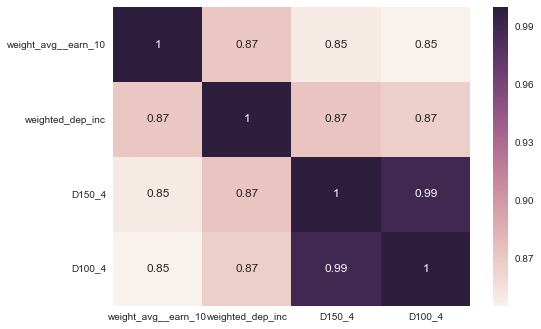

In [24]:
most_r = df_f[['weight_avg__earn_10', 'weighted_dep_inc', 'D150_4',  'D100_4']].copy()
sns.heatmap(most_r.corr(method='spearman'), annot=True)
#show that the factors that i identified that were the most relevant and
#correlated to the highest to earnings 10 years post graduation

## MDS into 2 components using dataframe with most relevant vaiables

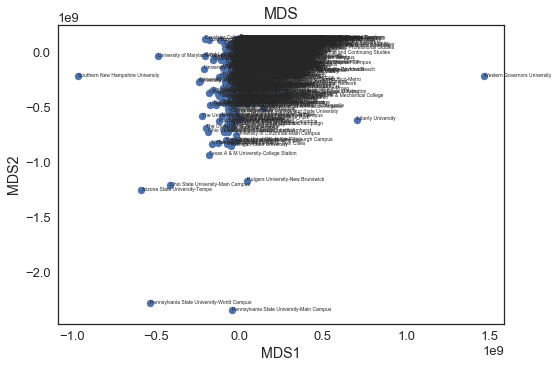

In [109]:
#MDS anaylisis with larger set of relevant variables identfied above
import sklearn.manifold as skm

X = skm.MDS(n_components=2).fit_transform(df_a[f_lst].copy())
plt.scatter(X[:,0],X[:,1],s=50)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS')

for i, s in enumerate(df_a[f_lst].copy().index):
    plt.annotate(s, xy=X[i,:2]+0.05, fontsize=5)

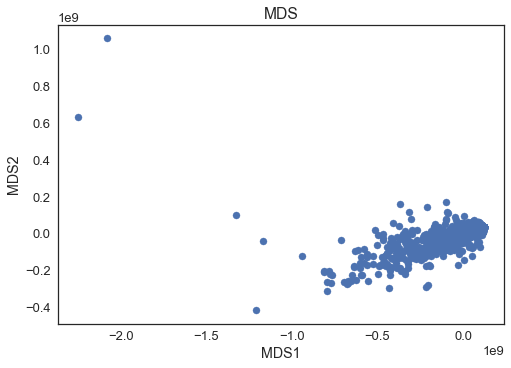

In [216]:
#mds with smaller dataframe of most relevant variables 
import sklearn.manifold as skm

X = skm.MDS(n_components=2).fit_transform(most_r)
plt.scatter(X[:,0],X[:,1],s=50)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS')

#removed annotations for readability 
# for i, s in enumerate(most_r.index):
#     plt.annotate(s, xy=X[i,:2]+0.05, fontsize=5)

#easier to read without labeling the data points, still similar to the other to PCA with the 25 relevant variables in regards to outliers 
##this shows how similar schools are based on my two MDS dimensions, thisshows  which schools are similar based on the reduced set of 
#most relevant variables, it is hard to tell from this which factors make the schools more similar
## note that outlier PEN state also has the highest weighted average earnings after 10 years

MDS Withe normalized data frame

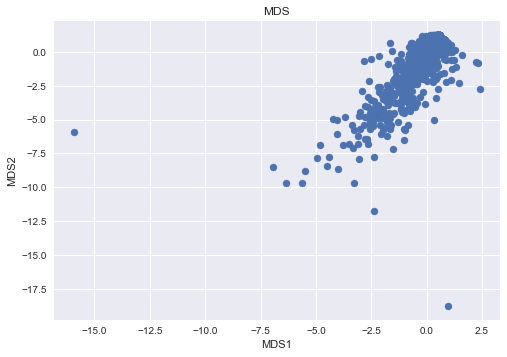

In [38]:
## MDS with normalized most_r dataframe 
#mds with smaller dataframe of most relevant variables 
import sklearn.manifold as skm
X = skm.MDS(n_components=2).fit_transform(normalized_df)
plt.scatter(X[:,0],X[:,1],s=50)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS')

#removed anotations for readability
# for i, s in enumerate(most_r.index):
#     plt.annotate(s, xy=X[i,:2]+0.05, fontsize=5)


##this shows how similar schools are based on my two MDS dimensions, thisshows  which schools are similar based on the reduced set of 
#most relevant normalized variables, it is hard to tell from this which factors make the schools more similar
# compared to the non normalized mds performed on the 4 most relevant variables, the results are similar -- demonstrating that normilazation has been acounted for in the relevant columns
## note that outlier PEN state also has the highest weighted average earnings after 10 years
# there is not much difference form the non normalized MDS on the most_r dataframe

## PCA analysis can we show similarity through less variables

PCA analysis with larger set of 25 relevant variables

In [197]:
#pca analysis on the smaller data frame larger set of 25 relevant variables
# Create a PCA model
pca_model = skd.PCA().fit(df_f.ix[:,:])

In [198]:
# There are 25 components extracted from the data; each component is
# a 25-dimensional vector.
pca_model.components_.shape

(26, 26)

In [199]:
# Look at the variances explained by each component.
# These values equal to the eigenvalues of the correlation matrix.
pca_model.explained_variance_

array([  3.63608148e+16,   2.74828304e+15,   1.11852513e+15,
         6.24156307e+08,   5.01051449e+07,   1.30287806e+07,
         5.24112060e+06,   3.07339126e+06,   2.32009565e+06,
         3.88011095e+05,   1.76526335e+05,   9.25446977e+03,
         8.36829755e-02,   7.47132038e-02,   5.94184952e-02,
         4.27334329e-02,   3.32475044e-02,   2.77869825e-02,
         1.99654188e-02,   1.51316084e-02,   1.23405130e-02,
         1.09568068e-02,   5.20598390e-03,   1.00157618e-03,
         2.40944945e-16,   2.40944945e-16])

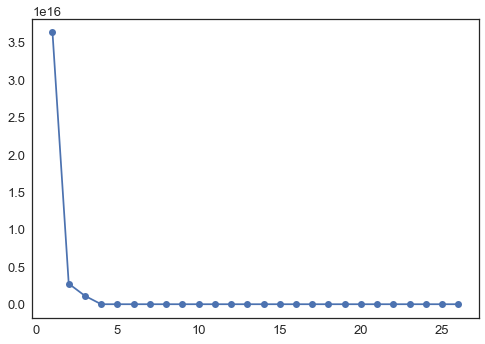

In [201]:
# A "scree" plot.
plt.plot(range(1,27),pca_model.explained_variance_,'b-o')
#from this we know to use 2 principal components

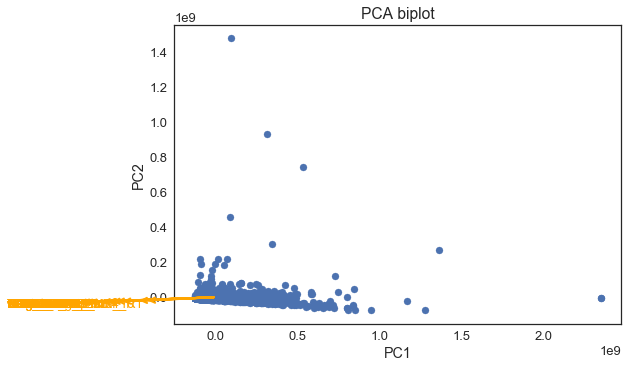

In [204]:
# Scatterplot of disaggregated data
X = pca_model.transform(df_f.ix[:,:])
# plt.figure(figsize=(14,14))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot')
#plt.ylim(-0.1, 10)

# Add variable unit vector projections
V = pca_model.transform(np.identity(X.shape[1]))
for i, v in enumerate(V):
    plt.annotate(df_f.columns[i], 
                 xy=(0,0), xytext=v[:2]*10, 
                 fontsize=13, color='orange',
                 arrowprops=dict(
                    arrowstyle='<-', linewidth=2, color='orange'))
    
    
 ##A LOT OF VARIABLES  ARE CORRELATEED WITH EACH OTHER AND THEY CAN BE EXPLAINED WITH 2 only two variables/ principle components

PCA with small set of most relevant variables found and in dataframe most_r, after this analyis, and from MDS I decided to more heavaly focus my analyis on the data in most_r

In [175]:
#pca analysis on the smaller data frame with the most relevent variables
# Create a PCA model
pca_model = skd.PCA().fit(most_r.ix[:,:])

In [176]:
# There are 25 components extracted from the data; each component is
# a 25-dimensional vector.
pca_model.components_.shape

(5, 5)

In [177]:
# Look at the variances explained by each component.
# These values equal to the eigenvalues of the correlation matrix.
pca_model.explained_variance_

array([  3.61493689e+16,   1.11902797e+15,   5.52745916e+05,
         9.41748964e+03,   3.11964233e-02])

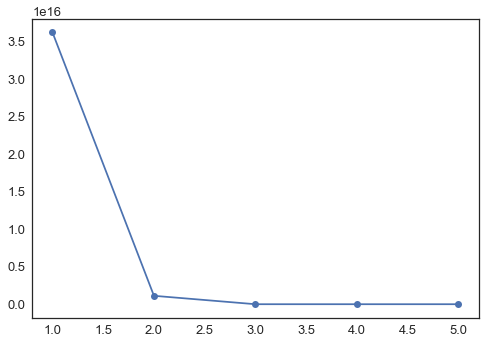

In [179]:
# A "scree" plot.
plt.plot(range(1,6),pca_model.explained_variance_,'b-o')
#from this we know to use 2 principal components

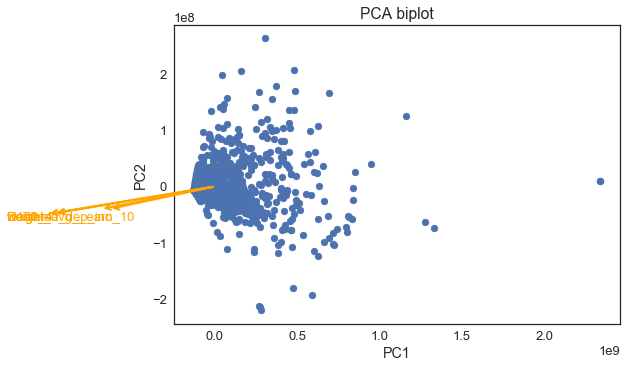

In [184]:
# Scatterplot of disaggregated data
X = pca_model.transform(most_r.ix[:,:])
# plt.figure(figsize=(14,14))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot')
#plt.ylim(-0.1, 10)

# Add variable unit vector projections
V = pca_model.transform(np.identity(X.shape[1]))
for i, v in enumerate(V):
    plt.annotate(most_r.columns[i], 
                 xy=(0,0), xytext=v[:2]*10, 
                 fontsize=13, color='orange',
                 arrowprops=dict(
                    arrowstyle='<-', linewidth=2, color='orange'))
    
    
 ##A LOT OF VARIABLES ARE CORRELATEED WITH EACH OTHER AND THEY CAN BE EXPLAINED WITH 2 only two variables/ principle components

PCA with normalized Dataframe

In [39]:
#pca analysis on the smaller nromalized dataframe of most 4 most relevant variables
# Create a PCA model
# was not usefull in the creation of PCA models, as errors occured
#pca_model = skd.PCA().fit(normalized_df.ix[:,:])
#ValueError: can only convert an array of size 1 to a Python scalar
#considering that the most_r variables has accounted for normilzation, PCA could not be performed with a new
# normilzed dataframe of the 4 most relevant colummns

## clustering classification and some further correlation analysis
need to add silouett plot

For n_clusters = 2 The average silhouette_score is : 0.759511217262


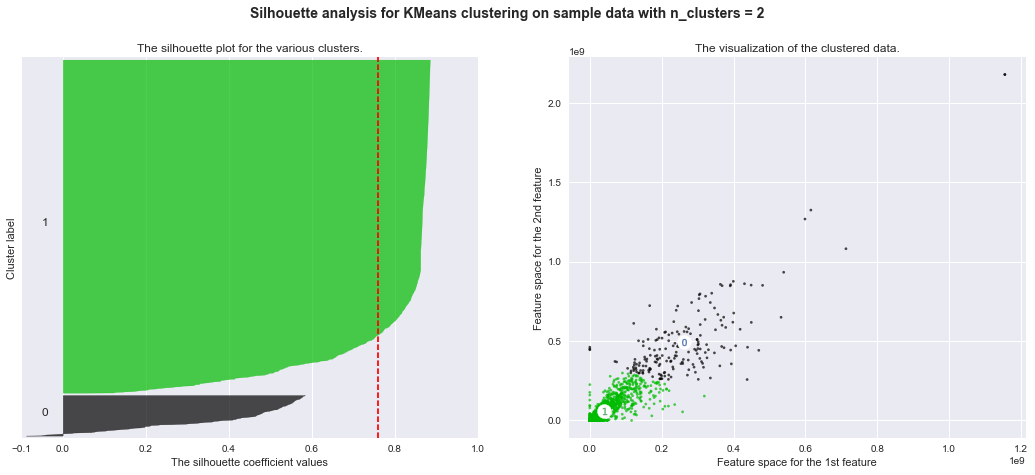

For n_clusters = 3 The average silhouette_score is : 0.701237844108


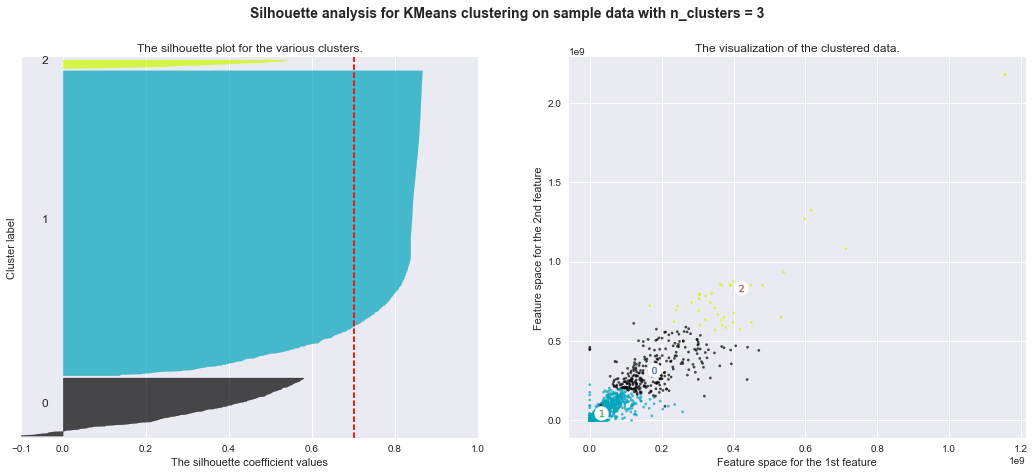

For n_clusters = 4 The average silhouette_score is : 0.638077366324


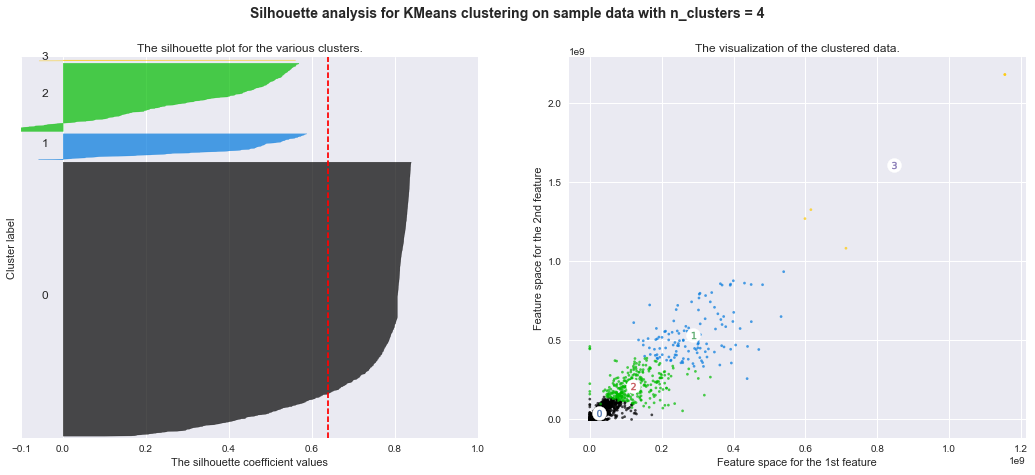

For n_clusters = 5 The average silhouette_score is : 0.637951768928


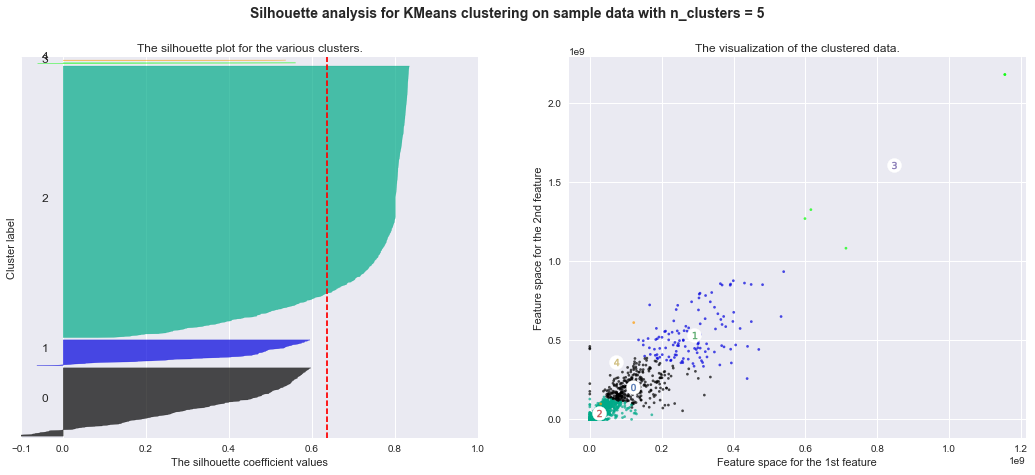

For n_clusters = 6 The average silhouette_score is : 0.610103588082


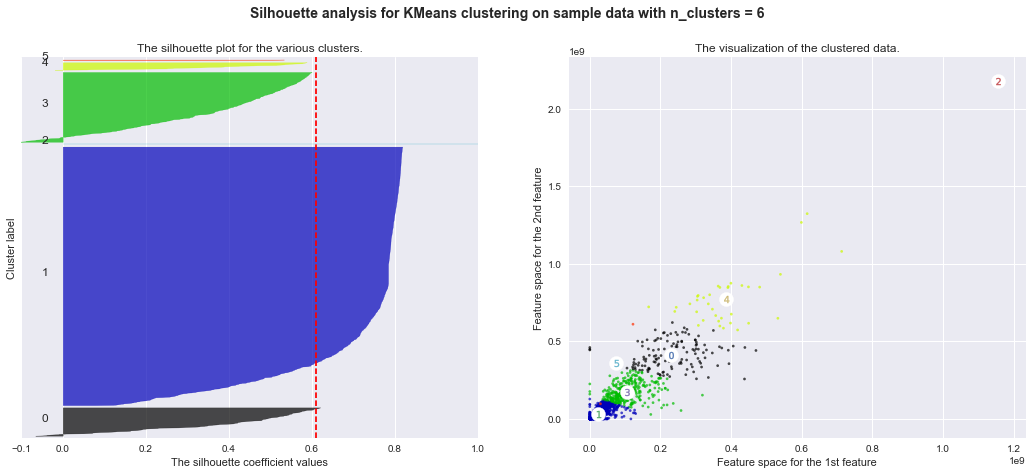

In [83]:
plotSilhouette(df_f)
# from these results along with ploting the silhouette coeficents, I determined to use a k means of 3

In [91]:
#this uses the larger list of relevant variables stored in f_lst for analysis of k means
##using the silouett method i was able to identify that the highes coeffcient number of clusters for k means to be 2 
# from interpreting the graphs above i determined that the best number of clusters to be 3
#silouet method for clustering k means
X = df_a[f_lst].copy()  # Using the the dataset of Section 1
K = range(2,11)  # Apply kmeans 2 to 10
import sklearn
# run k-means for eachk
KM = [skc.KMeans(n_clusters=k).fit(X) for k in K]

# Note that silhouette_score is unhappy with k=1
# calculate the silhouette for each model
silh_scores = [skm.silhouette_score(X,km.labels_) for km in KM]

# find the best score
kIdx = np.argmax(silh_scores)

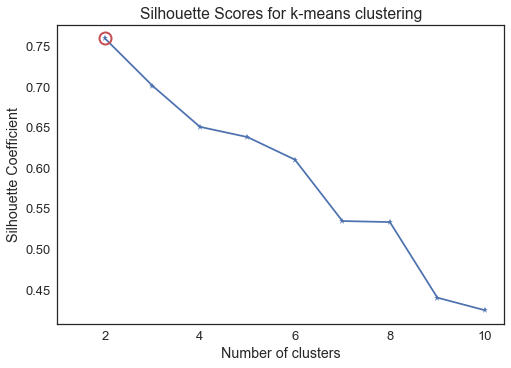

In [92]:
# plot the silhouette scores
plt.plot(K, silh_scores, 'b*-')
plt.plot(K[kIdx], silh_scores[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette Coefficient');
plt.title('Silhouette Scores for k-means clustering');

In [84]:
kmeans_model = skc.KMeans(n_clusters=3).fit(df_f)
# find the centroids
centroids = kmeans_model.cluster_centers_
# find the "labels"
cluster_labels = kmeans_model.labels_
# count how many of each we have
print(pd.value_counts(cluster_labels))
#creates a column with cluster lables
df_f['cluster'] = cluster_labels

0    1423
1     272
2      40
dtype: int64


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Because clusting with the larger dataset and the smaller data set of relevant variables produced very similar clusting results, i decided to focus on the most relevant variable contained in the smaller dataframe most_r

For n_clusters = 2 The average silhouette_score is : 0.768826246042


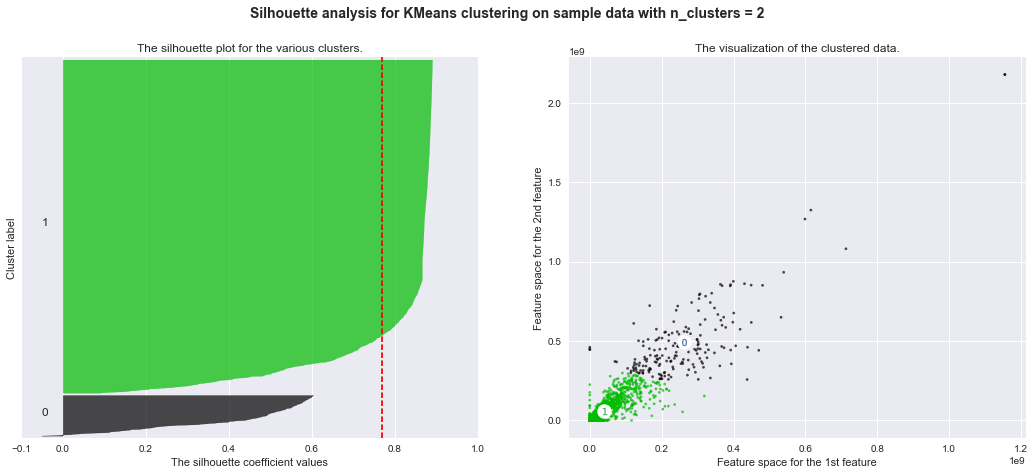

For n_clusters = 3 The average silhouette_score is : 0.713498703114


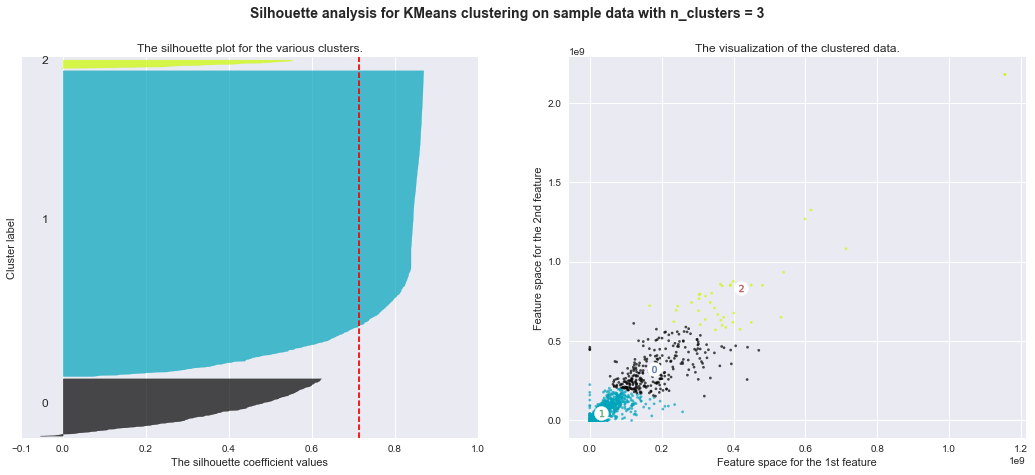

For n_clusters = 4 The average silhouette_score is : 0.654561721399


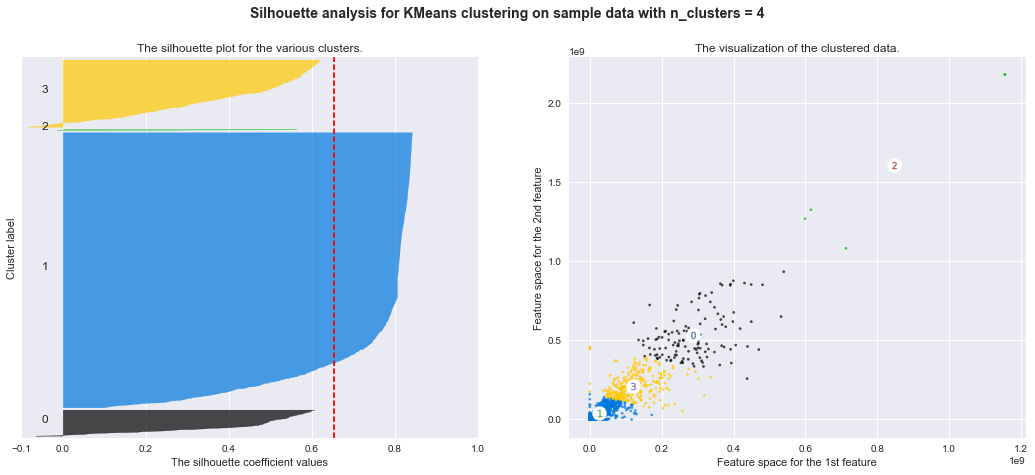

For n_clusters = 5 The average silhouette_score is : 0.621930584677


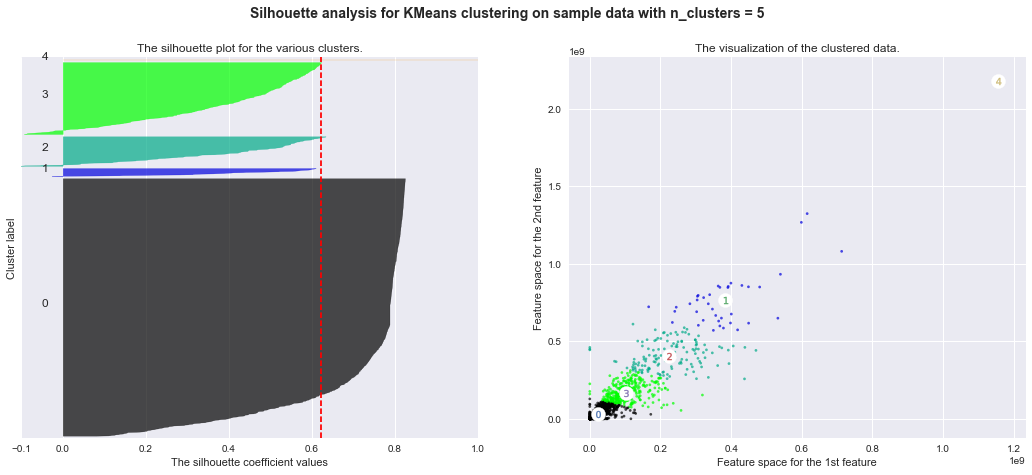

For n_clusters = 6 The average silhouette_score is : 0.555114545068


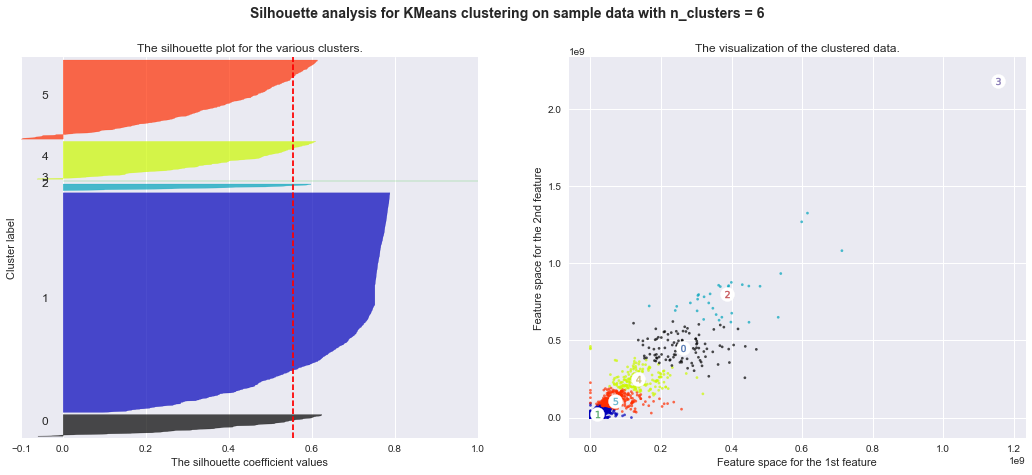

In [85]:
plotSilhouette(most_r)
#from these results it seems that the best number for K means to be 3

In [88]:
#k means analysis with smaller dataframe with only most relevant vars 
#using smaller dataframe with more highly correlated values i tried if there was a more effect number of clusters
##using the silouett method i was able to reafirm that the best number of clusters for k means to be 2 

#silouet method for clustering k means
X =most_r.copy()  # Using the the dataset of Section 1
K = range(2,11)  # Apply kmeans 2 to 10

# run k-means for each k
KM = [skc.KMeans(n_clusters=k).fit(X) for k in K]

# Note that silhouette_score is unhappy with k=1
# calculate the silhouette for each model
silh_scores = [skm.silhouette_score(X,km.labels_) for km in KM]

# find the best score
kIdx = np.argmax(silh_scores)

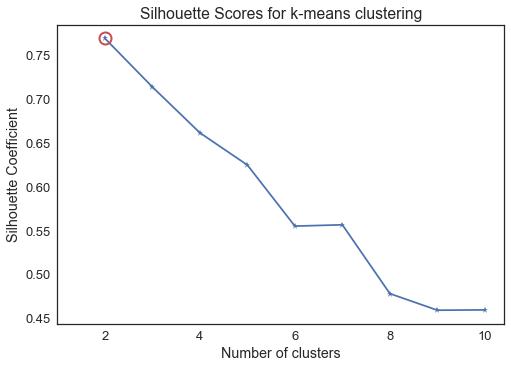

In [89]:
# plot the silhouette scores
plt.plot(K, silh_scores, 'b*-')
plt.plot(K[kIdx], silh_scores[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette Coefficient');
plt.title('Silhouette Scores for k-means clustering');

In [86]:
#while the silhouette coef plot shows that 2 is the best number of clusters for k means, after interpreting the results of the 
#silouett plot i decided to use 3 clusters 
kmeans_model = skc.KMeans(n_clusters=3).fit(most_r)
# find the centroids
centroids = kmeans_model.cluster_centers_
# find the "labels"
cluster_labels = kmeans_model.labels_
# count how many of each we have
print(pd.value_counts(cluster_labels))
#creates a column with cluster lables
most_r['cluster'] = cluster_labels

0    1427
1     268
2      40
dtype: int64


In [94]:
c1 = most_r[most_r['cluster'] == 0]
c2 = most_r[most_r['cluster'] == 1]
c3 = most_r[most_r['cluster'] == 2]


removes 0s in both clusters to acount for the missing values in the data, and plots correlations using spearmans r

r squared for cluster 0  0.601483061217 for dependents
r squared for cluster 1  0.334058460503 for dependents
r squared for cluster 2  0.182778510036 for dependents


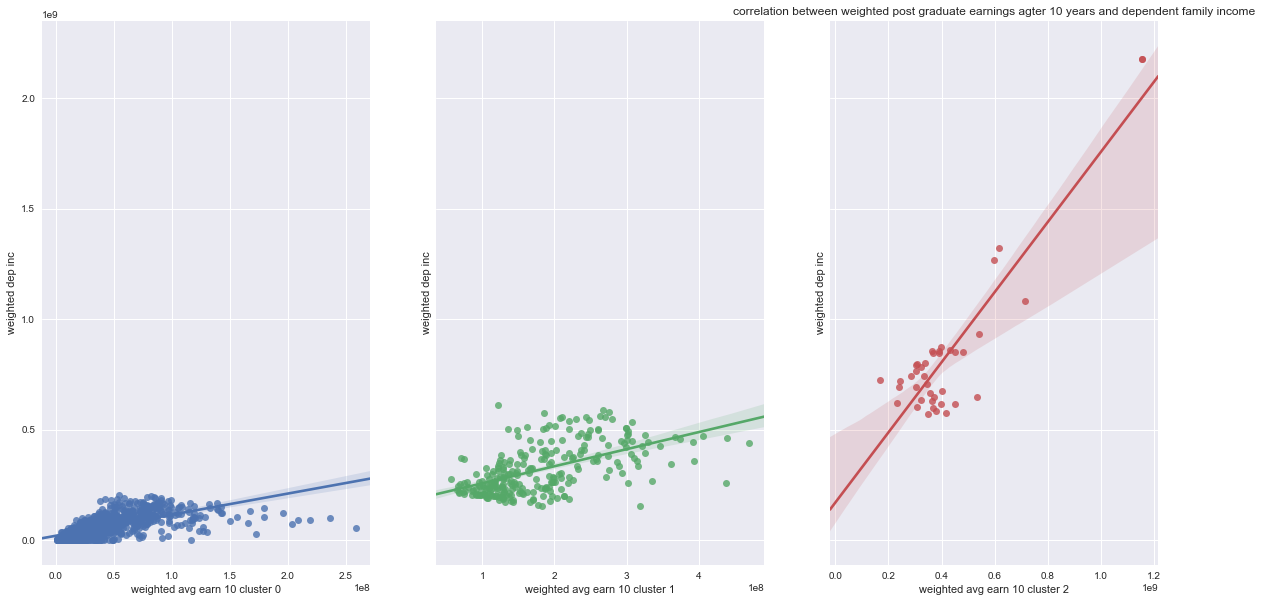

In [221]:
print("r squared for cluster 0 ", r2(c1['weight_avg__earn_10'][c1['weight_avg__earn_10'] != 0], c1['weighted_dep_inc'][c1['weight_avg__earn_10'] != 0]), "for dependents")
print("r squared for cluster 1 ", r2(c2['weight_avg__earn_10'][c2['weight_avg__earn_10'] != 0], c2['weighted_dep_inc'][c2['weight_avg__earn_10'] != 0]), "for dependents")
print("r squared for cluster 2 ", r2(c3['weight_avg__earn_10'][c3['weight_avg__earn_10'] != 0], c3['weighted_dep_inc'][c3['weight_avg__earn_10'] != 0]), "for dependents")

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True,figsize=(20,10))
ax1 = sns.regplot(x=c1['weight_avg__earn_10'][c1['weight_avg__earn_10'] != 0], y=c1['weighted_dep_inc'][c1['weight_avg__earn_10'] != 0], ax=ax1)
ax2 = sns.regplot(x=c2['weight_avg__earn_10'][c2['weight_avg__earn_10'] != 0], y=c2['weighted_dep_inc'][c2['weight_avg__earn_10'] != 0], ax=ax2)
ax3 = sns.regplot(x=c3['weight_avg__earn_10'][c3['weight_avg__earn_10'] != 0], y=c3['weighted_dep_inc'][c3['weight_avg__earn_10'] != 0], ax=ax3)
# ax = sns.regplot(weighted_ind_inc, weighted_avg_earn_10  )
ax1.set(xlabel='weighted avg earn 10 cluster 0', ylabel='weighted dep inc')
plt.title("correlation between weighted post graduate earnings agter 10 years and dependent family income")
ax2.set(xlabel='weighted avg earn 10 cluster 1', ylabel='weighted dep inc')
ax3.set(xlabel='weighted avg earn 10 cluster 2', ylabel='weighted dep inc')
plt.show()


# removes schools that have 0 values as nulls and missing data were converted to 0s 
##shows the relationship between dependends family income and weighted mean earnings after 10 years for cluster 0, 1, and 2
# there is no real corelation betwean earnings and family income in cluser 2, but cluster 2 has schools with the most earning potential
# the is a moderate correlation of 0.60 in cluster 0s dependent family income and post graduate earnings, but contains schools with
# the lowest potential for high earnings
#cluster 1 has some correlation but it is not enough to make any diffinitive analysis other than it contains schools with moderate
# potential for larger inclome
#going to schools in cluster 1 alows for more acurate preiction of earnings 

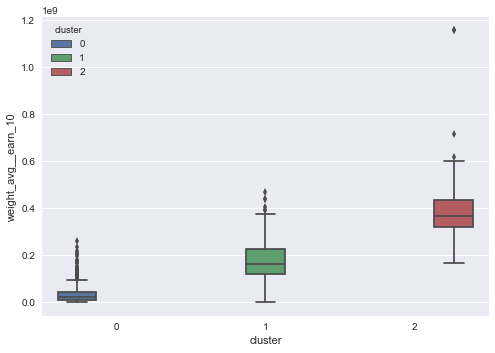

In [106]:

sns.boxplot(x="cluster", y="weight_avg__earn_10", hue="cluster", data=most_r);

#
#outliers are not of concern as weighted variables were created and normilzation was accounted for in the original dataset
# for the most relevant variables
#cluster 0 contains schools where students have on average the lowest earning potential after 10 years, 
# cluster 1 shows schools in cluster that have middle earning potential 
#cluster 2 identifies schools that have the largest earning potential 

## clustering with k means and mds

In [111]:
import sklearn.manifold as skm

most_r_mds = most_r.copy()
coords = skm.MDS(n_components=2).fit_transform(most_r_mds)
x = [d[0] for d in coords]
y = [d[1] for d in coords]

In [128]:
kmeans_model = skc.KMeans(3).fit(most_r_mds)
most_r_mds['x'] = x
most_r_mds['y'] = y
most_r_mds['cluster_label'] = kmeans_model.labels_

In [116]:
# we want the x/y of the centroids in the transformed MDS space
centroids_mds = most_r_mds.groupby("cluster_label").mean()[['x',
                                                               'y']].as_matrix()

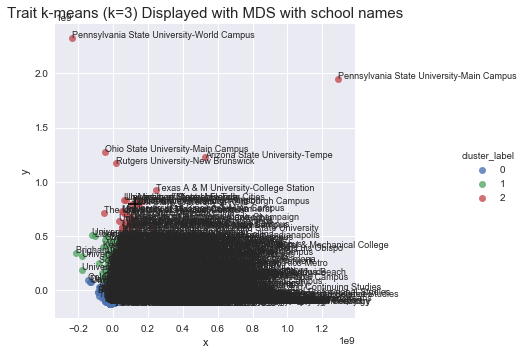

In [146]:
f = sns.lmplot(x='x', y='y', data=most_r_mds, 
               hue='cluster_label',
               fit_reg=False)
f.ax.scatter(centroids_mds[:,0], 
             centroids_mds[:,1], 
             marker='+', s=200,
             linewidths=2, color='black');
plt.title('Trait k-means (k=3) Displayed with MDS with school names',
          fontsize=15)
# Annotate each individual person's name
for i, name in enumerate(most_r_mds.index):
    plt.annotate(name, (x[i]+0.02, y[i]+0.05), 
                 fontsize=9)

#with school names 

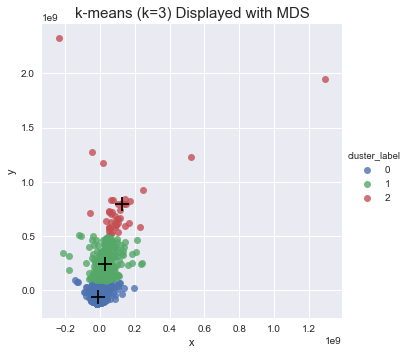

In [129]:
f = sns.lmplot(x='x', y='y', data=most_r_mds, 
               hue='cluster_label',
               fit_reg=False)
f.ax.scatter(centroids_mds[:,0], 
             centroids_mds[:,1], 
             marker='+', s=200,
             linewidths=2, color='black');
plt.title('k-means (k=3) Displayed with MDS', 
          fontsize=15)

#without school names 

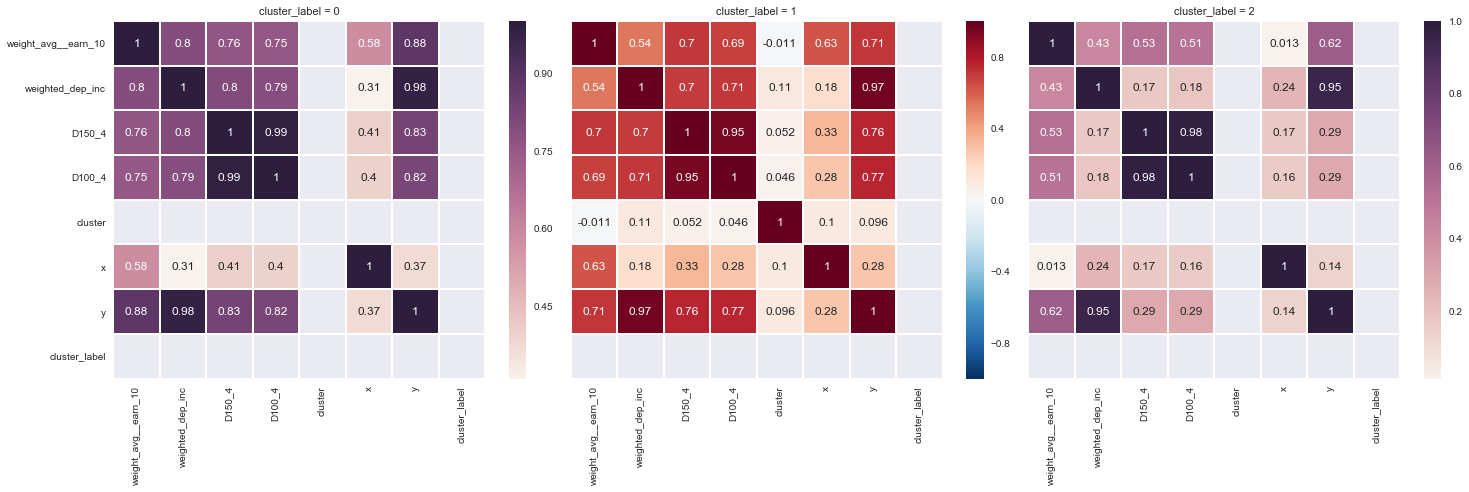

In [213]:
g = sns.FacetGrid(most_r_mds, col='cluster_label', size=7)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr('spearman'),annot=True, linewidths=1))

In [141]:
mds_c1 = most_r_mds[most_r_mds['cluster_label'] == 0]
mds_c2 = most_r_mds[most_r_mds['cluster_label'] == 1]
mds_c3 = most_r_mds[most_r_mds['cluster_label'] == 2]

print(mds_c3.shape)
print(mds_c3.shape)
print(mds_c3.shape)

(40, 8)
(40, 8)
(40, 8)


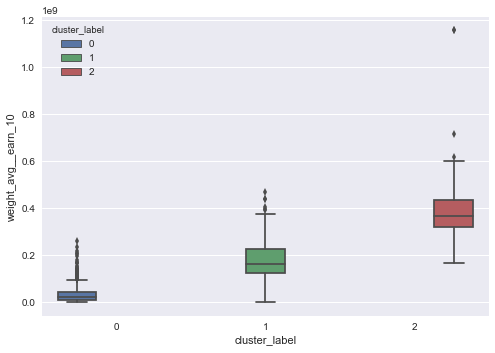

In [142]:
#shows the distribution of the weighted average eaernins after 10 years for cluster 0 and 1 
sns.boxplot(x="cluster_label", y="weight_avg__earn_10", hue="cluster_label", data=most_r_mds);
#shows that students who go to cluster 0 schools make more money 10 years after college, than those who attend schools of 
#cluster 0

In [164]:
most_r_mds[most_r_mds['weight_avg__earn_10'] != 0].describe()

weight_avg__earn_10  weighted_dep_inc       D150_4       D100_4  \
count         1.556000e+03      1.556000e+03  1556.000000  1556.000000   
mean          7.107282e+07      1.196642e+08   886.857969   861.594473   
std           9.544288e+07      1.743079e+08  1154.407406  1141.405104   
min           1.153600e+06      0.000000e+00     0.000000     0.000000   
25%           1.795155e+07      2.546705e+07   215.750000   201.000000   
50%           3.571110e+07      5.703467e+07   456.500000   443.000000   
75%           8.396270e+07      1.398331e+08  1038.500000  1010.500000   
max           1.155015e+09      2.177558e+09  8038.000000  8038.000000   

           cluster             x             y  cluster_label  
count  1556.000000  1.556000e+03  1.556000e+03    1556.000000  
mean      0.221722  1.677520e+06  1.277981e+07       0.222365  
std       0.473413  5.027586e+07  1.921875e+08       0.473790  
min       0.000000 -2.333719e+08 -1.249419e+08       0.000000  
25%       0.000000 -1.535083e+07 -9.432033e+07       0.000000  
50%       0.000000 -8.813201e+06 -5.910875e+07       0.000000  
75%       0.000000  4.591551e+06  3.910784e+07       0.000000  
max       2.000000  1.291350e+09  2.326730e+09       2.000000

In [159]:
mds_c1[mds_c1['weight_avg__earn_10'] != 0].describe()

weight_avg__earn_10  weighted_dep_inc       D150_4       D100_4  \
count         1.250000e+03      1.250000e+03  1250.000000  1250.000000   
mean          3.630400e+07      5.415961e+07   441.732000   425.070400   
std           3.163510e+07      4.489071e+07   368.402814   354.892189   
min           1.153600e+06      0.000000e+00     0.000000     0.000000   
25%           1.469305e+07      1.994336e+07   174.000000   163.000000   
50%           2.749505e+07      4.247657e+07   349.000000   341.500000   
75%           4.838910e+07      7.874932e+07   599.250000   583.000000   
max           2.582052e+08      2.028266e+08  2124.000000  2090.000000   

       cluster             x             y  cluster_label  
count   1250.0  1.250000e+03  1.250000e+03         1250.0  
mean       0.0 -7.649638e+06 -6.088934e+07            0.0  
std        0.0  2.004923e+07  5.084812e+07            0.0  
min        0.0 -1.414868e+08 -1.249419e+08            0.0  
25%        0.0 -1.577616e+07 -1.008734e+08            0.0  
50%        0.0 -1.089129e+07 -7.335690e+07            0.0  
75%        0.0 -2.590629e+06 -3.182430e+07            0.0  
max        0.0  1.986821e+08  9.448788e+07            0.0

In [160]:
mds_c2[mds_c2['weight_avg__earn_10'] != 0].describe()

weight_avg__earn_10  weighted_dep_inc       D150_4       D100_4  \
count         2.660000e+02      2.660000e+02   266.000000   266.000000   
mean          1.820028e+08      3.196717e+08  2353.988722  2296.007519   
std           7.966068e+07      1.114740e+08  1057.900029  1084.704697   
min           5.664060e+07      1.442438e+08     0.000000     0.000000   
25%           1.226419e+08      2.289852e+08  1572.250000  1517.250000   
50%           1.652220e+08      2.893695e+08  2104.500000  2032.500000   
75%           2.261968e+08      3.937964e+08  2945.500000  2938.500000   
max           4.702302e+08      6.111238e+08  6382.000000  6382.000000   

          cluster             x             y  cluster_label  
count  266.000000  2.660000e+02  2.660000e+02          266.0  
mean     0.996241  2.701458e+07  2.414670e+08            1.0  
std      0.061314  5.226033e+07  1.233496e+08            0.0  
min      0.000000 -2.104491e+08  8.549475e+07            1.0  
25%      1.000000 -3.285480e+06  1.360628e+08            1.0  
50%      1.000000  2.283375e+07  2.101973e+08            1.0  
75%      1.000000  5.577555e+07  3.314796e+08            1.0  
max      1.000000  2.155846e+08  5.168640e+08            1.0

In [161]:
mds_c3[mds_c3['weight_avg__earn_10'] != 0].describe()

weight_avg__earn_10  weighted_dep_inc      D150_4       D100_4  \
count         4.000000e+01      4.000000e+01    40.00000    40.000000   
mean          4.199138e+08      8.366317e+08  5040.62500  4964.125000   
std           2.013715e+08      3.533687e+08  1567.37541  1585.434975   
min           1.666008e+08      5.709421e+08    36.00000    20.000000   
25%           3.175509e+08      6.460015e+08  3882.00000  3866.500000   
50%           3.681207e+08      7.424274e+08  5001.00000  5001.000000   
75%           4.350880e+08      8.525478e+08  6142.00000  6142.000000   
max           1.155015e+09      2.177558e+09  8038.00000  8038.000000   

       cluster             x             y  cluster_label  
count     40.0  4.000000e+01  4.000000e+01           40.0  
mean       2.0  1.246598e+08  7.941712e+08            2.0  
std        0.0  2.160370e+08  3.600627e+08            0.0  
min        2.0 -2.333719e+08  5.311700e+08            2.0  
25%        2.0  5.620086e+07  6.004115e+08            2.0  
50%        2.0  8.894567e+07  6.913750e+08            2.0  
75%        2.0  1.314901e+08  8.083675e+08            2.0  
max        2.0  1.291350e+09  2.326730e+09            2.0

MDS with clustering for normalized_df of 4 most relevant var

In [162]:
#same as above with normalmalized_df of most_r
# seeing if normalization can account for differences in similarity 
# i feel because the variables in the most_r df have already acounted for normalization that these results will not
#differ much from the results with out the normilzation done

normalized_df_mds = normalized_df.copy()
coords = skm.MDS(n_components=2).fit_transform(normalized_df_mds)
x = [d[0] for d in coords]
y = [d[1] for d in coords]
normalized_df['x'] = x
normalized_df['y'] = y
# we want the x/y of the centroids in the transformed MDS space
centroids_mds = most_r_mds.groupby("cluster_label").mean()[['x',
                                                               'y']].as_matrix()


In [166]:
kmeans_model = skc.KMeans(3).fit(normalized_df_mds)
normalized_df_mds['x'] = x
normalized_df_mds['y'] = y
normalized_df_mds['cluster_label'] = kmeans_model.labels_

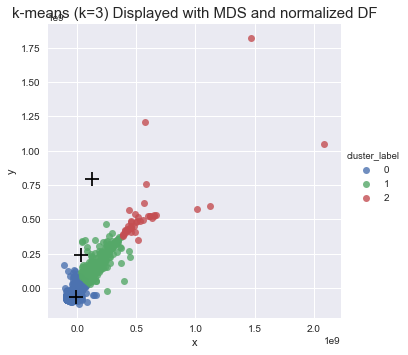

In [170]:
f = sns.lmplot(x='x', y='y', data=normalized_df_mds, 
               hue='cluster_label',
               fit_reg=False)
f.ax.scatter(centroids_mds[:,0], 
             centroids_mds[:,1], 
             marker='+', s=200,
             linewidths=2, color='black');
plt.title('k-means (k=3) Displayed with MDS and normalized DF', 
          fontsize=15)

#without school names 

In [171]:
n_mds_c1 = most_r_mds[most_r_mds['cluster_label'] == 0]
n_mds_c2 = most_r_mds[most_r_mds['cluster_label'] == 1]
n_mds_c3 = most_r_mds[most_r_mds['cluster_label'] == 2]

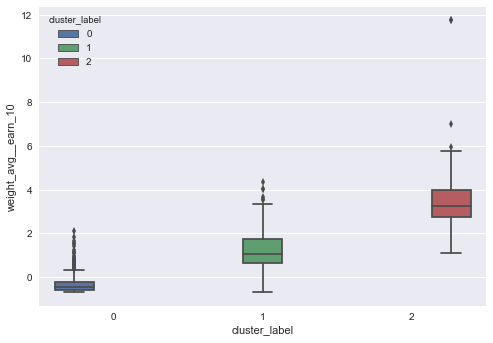

In [172]:
#shows the distribution of the weighted average eaernins after 10 years for cluster 0 and 1 
sns.boxplot(x="cluster_label", y="weight_avg__earn_10", hue="cluster_label", data=normalized_df_mds);
#shows that students who go to cluster 0 schools make more money 10 years after college, than those who attend schools of 
#cluster 0

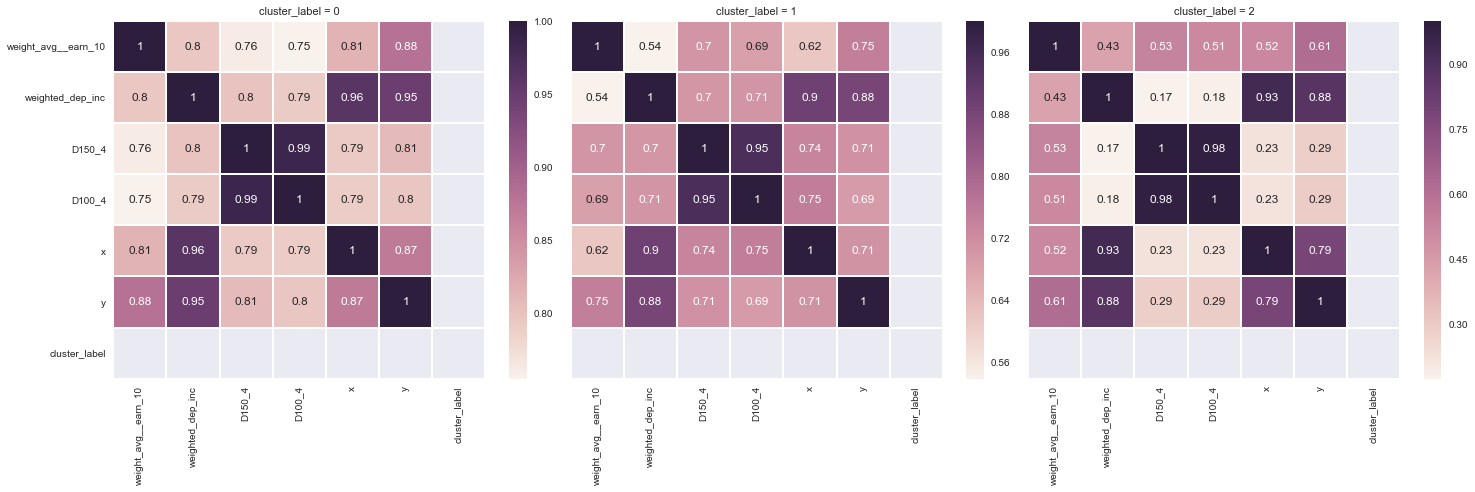

In [212]:

g = sns.FacetGrid(normalized_df_mds, col='cluster_label', size=7)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr('spearman'),annot=True, linewidths=1))